# _Text Normalization and Tokenization_

Machine learning algorithms technically don't work with text data, however, there is a workaround for this. By pre-processing the text, and then converting it into a numerical format (i.e. vectors of numbers), it is then in an appropriate format that can be fed into ML algorithms. But what does text pre-processing entail exactly?  

This is where things get interesting. From a high-level, preprocessing removes as much noise as possible from the text data, that way an algorithm can more readily find any potential patterns. But determining what is noise and what is not is significantly impacted by the type of text. For example, you do not want to use the same text pre-processing techniques when you are analyzing Tweets versus when you are analyzing novels. Sure, there may be some overlap, but these two examples of text are significantly different not only in their function but in the text patterns that exist within them (after all, you won't see any emojis in Dostoyevsky's __The Brothers Karamazov__...)

That being said there are some central core of text processing strategies that will help you get started:
- __Lower casing__: by lowercasing all of the text data, it allows us to capture a word that may have multiple spellings due to miscellaneous uppercasing. For example, a text may include: `America`, `aMerica`, and `AMERICA`. Now we know these are all the same word, however, machines don't, they think these are three different words. To help our computer come to its senses, we lowercase all the text so it can then recognize three cases of `america`, instead of one case of three words. 
- __Stemming__: This means looking for the "root" of a word. There are plenty of words that have multiple inflections. Take the word `connect`; some of its inflections include: `connected`, `connection`, and `connects`. With stemming, we can crudely change the inflection words to the root word by chopping off their endings.
- __Lemmatization__: Similar to stemming, in that its goal is to remove inflections, but it does it in a less crude way. It attempts to transform words to the actual root. Take the word `geese`, which is an inflection of `goose`. By using lemmatization, we can change it back into its original root (versus simply chopping off the letters at the end). 
- __Removing Stopwords__: When you are dealing with text, a lot of the words used actually provide no significant value. Examples include `a`, `this`, `and`, etc. What is the benefit of this? In theory, it allows us to keep only the important words. Lets take a look at the following sentence: `John is going to the store.` Now, let's remove `is`, `to`, and `the`: `John going store`. While it isn't grammatically correct, you still get the primary concept, that John is going to the store. While humans may think it's weird to read the above, this strategy has the potential to help a machine. 
- __Text Normalization__: Due to the character limits for Tweets, people will often use non-standard forms of words. One such example would be the use of `omg`, which stands for `oh my god`; another example would be the use of `2mrw` as a stand in for the word `tomorrow`. As I mentioned, this is pretty common pattern in social media text, so is a technique to seriously consider for this project. 
- __Text Enrichment / Augmentation__: Believe it or not, this strategy augments (i.e. adds) information that wasn't previously there before in hopes that can improve its predictive power. Sub-strategies could include things like part-of-speech tagging, or dependency parsing. 

With this background in mind, let's turn our attention to developing a function that will clean our Tweet data. This is v2 of the text preprocessing component of our pipeline; the first version can be found in the `8.1-je-text-normal-token` Jupyter Notebook.

In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%matplotlib inline

### _Our test Tweet_

Below is `testtweet`, which contains an actual tweet from the data we've gathered, with a few modifications. I've added the following terms/items (i.e. these weren't in the original Tweet):

- every newline character (e.g. `\n`)
- `Sars-Cov-2`
- `corona virus`
- the emoji (🧐)
- `#coronavirus`
- the YouTube link
- random GitHub link from Ryan's tutorial repository

The reason that I had this information is that each one represents a potential part that we must catch in our text preprocessing phase. We need to remove newline-characters because they provide next to no value; we need to account for emojis and replace them with special tokens to preserve that there was an emoji in the Tweet; we need to standardize various coronavirus/covid-related terms, both in regards to normal text and hashtags; and we need to address for the various types of URLs that are present. 

In [2]:
testtweet = """Sars-Cov-2 @narendramodi Dear PM, Is this really happening?\n\nThe countrymen have to pay for COVID-19 
corona virus #Covid19 Tests?  🧐 Unbelievable! \n #coronavirus pic.twitter.com/31nvInjcBZ 
https://www.youtube.com/watch?v=ig9yh8iVZWI
https://github.com/rkingery/ml_tutorials/blob/master/notebooks/ml_with_text.ipynb
"""

### _v2 Text Preprocessing Functions_

V1 of the text preprocessing component threw away or manipulated too much of the text data. Our primary focus with V2 is to retain as much information from the original Tweet as possible. With this in mind, lets turn our attention to the functions below.

- `newline_remove`: replaces newline characters (e.g. `\n`)
- `replace_coronavirus`: standardizes coronavirus term within text to `coronavirus`
- `coronavirus_hashtags`: any instances of `#coronavirus` are replaced with special token `xxhashcoronavirus`
- `replace_covid`: standardizes COVID-19 within text to `covid19`
- `covid_hashtags`: any instances of `#covid19` are replaced with special token `xxhashcovid19`
- `sarscov2_replace`: accounts for any mention of `SARS-CoV-2` and standardizes to `sarscov2`
- `emoji_replace`: replaces any emojis (e.g. 😉) in a given text with a special token `xxemoji`
- `twitterpic_replace`: if there is a link to a picutre in a format similar to `pic.twitter.com/`, we replace that substring with a special token `xxpictwit`
- `youtube_replace`: similar to the above, but geared specifically to any YouTube links, replacing them with `xxyoutubeurl`
- `url_replace`: again similar to the above, but geared specifically for any other miscellaneous URLs, replacing them with `xxurl`
- `punctuation_replace`: ensures that punctuation has one space on either side of the character (makes it easier to pick out)
- `clean_wrapper`: wrapper function that includes all the functions mentioned above

Additionally, `clean_wrapper` has some extra functionality that gives us a little more flexbility to try and compare different preprocessing strategies.

In [33]:
%%writefile sim_wrapper.py
import re
import string
import emoji
from nltk.tokenize import RegexpTokenizer, regexp_tokenize

def newline_remove(text):
    regex = re.compile(r'\n+', re.I)
    text = regex.sub(' ', text)
    return text


def replace_coronavirus(text):
    regex = re.compile(r'(corona[\s]?virus)', re.I)
    return regex.sub('coronavirus', text)


def coronavirus_hashtags(text):
    regex = re.compile(r'#(coronavirus)\b', re.I)
    return regex.sub('xxhashcoronavirus', text)


def replace_covid(text):
    regex = re.compile(r'(covid[-\s_]?19)', re.I)
    return regex.sub('covid19', text)


def covid_hashtags(text):
    regex = re.compile(r'#(covid[_-]?(19))', re.I)
    return regex.sub('xxhashcovid19', text)


def sarscov2_replace(text):
    regex = re.compile(r'(sars[-]?cov[-]?2)', re.I)
    return regex.sub(r'sarscov2', text)


def emoji_replace(text):
    # first demojize text
    new_text = emoji.demojize(text, use_aliases=True)
    regex = re.compile(r"(:\S+:)", re.I)
    return regex.sub(" xxemoji ", new_text)


def twitterpic_replace(text):
    regex = re.compile(r"pic.twitter.com/\w+", re.I)
    return regex.sub("xxpictwit", text)


def youtube_replace(text):
    regex = re.compile(r"(https://youtu.be/(\S+))|(https://www.youtube.(\S+))", re.I)
    return regex.sub("xxyoutubeurl", text)


def url_replace(text):
    regex = re.compile(r"(?:http|ftp|https)://(\S+)", re.I)
    return regex.sub("xxurl", text)


def punctuation_replace(text):
    # put spaces between punctuation
    PUNC = string.punctuation + '…–”“’'
    punct = r"[" + re.escape(PUNC) + r"]"
    text = re.sub("(?<! )(?=" + punct + ")|(?<=" + punct + ")(?! )", r" ", text)
    text = re.sub(r"[^\w\s]",'',text) # could replace with xxpunc
    # remove any extra whitespace
    text = re.sub(r'[ ]{2,}',' ',text)
    return text


def clean_wrapper(text, nltk_tokenize=False, punc_replace=False, preprocessor=False, ):
    PUNC = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~…–”“’'
    # removes newline characters from text
    text = newline_remove(text)
    # standardizes all instances of coronavirus in text
    text = replace_coronavirus(text)
    # replaces instances of #coronavirus with special token, xxhashcoronavirus
    text = coronavirus_hashtags(text)
    # standardizes all instances of covid19
    text = replace_covid(text)
    # replaces instances of #covid19 with special token, xxhashcovid19
    text = covid_hashtags(text)
    # standardizes SARS-Cov-2 to sarscov2
    text = sarscov2_replace(text)
    # removes hashtag characters
    # text = text.replace(r'#', '')
    # removes @ character
    # text = text.replace(r'@', '')
    # if preprocessor set to True, use preprocessor library to process tweet
    if preprocessor == True:
        p.set_options(p.OPT.NUMBER)
        text = p.tokenize(text)
        text = emoji_replace(text)
        if punc_replace == True:
            text = punctuation_replace(text)
        text = " ".join(word for word in text.split() if len(word) > 1)
        return text.strip()
    # replace emojies with special token xxemoji
    text = emoji_replace(text)
    # replace pic.twitter.com links with special token, xxpictwit
    text = twitterpic_replace(text)
    # replace YouTube links with special token, xxyoutubeurl
    text = youtube_replace(text)
    # replace other URLs with special token, xxurl
    text = url_replace(text)
    # if nltk_tokenize parameter True, then use regexp_tokenize from nltk library
    if nltk_tokenize == True:
        text = " ".join(RegexpTokenizer('\s+', gaps=True).tokenize(text))
        text = "".join(char for char in text if char not in PUNC)
    # if punc_replace set to True, replace all punctuations
    if punc_replace == True:
        text = punctuation_replace(text)
    # remove any unnecessary whitespace
    text = re.sub(r'[ ]{2,}',' ',text)
    return text.strip()

Overwriting sim_wrapper.py


## _Testing Our Text Cleaner_

So we've defined our prerequisite functions, now what do we do? We test to see how fast it works. Because the ultimate aim of this project is to be able to detect potential misinformation in near real-time (i.e. as people scroll through their feeds), we need everything to be as quick as possible. This gives us the opportunity to break down everything with `line_profiler`; more specifically, we'll be using the `%lprun` IPython magic. This will give us a line-by-line report of the `clean_wrapper` function, that'll show us how long each step is taking. If there seem to be any bottlenecks, we can dive deeper from there. 

Additionally, I made a Python script of the cell above, called `sim_wrapper.py` (using another form of IPython magic, `%%makefile`) because `%lprun` tends to [work better when a function is defined in a file](https://ipython-books.github.io/43-profiling-your-code-line-by-line-with-line_profiler/)

After that we'll import the script and run `%lprun`, outputting the report in a file named `sim_wrapper_test`. 

In [20]:
# import libraries and refamiliarize ourselves with our test tweet
import pandas as pd
from sim_wrapper import *
print(testtweet)

Sars-Cov-2 @narendramodi Dear PM, Is this really happening?

The countrymen have to pay for COVID-19 
corona virus #Covid19 Tests?  🧐 Unbelievable! 
 #coronavirus pic.twitter.com/31nvInjcBZ 
https://www.youtube.com/watch?v=ig9yh8iVZWI
https://github.com/rkingery/ml_tutorials/blob/master/notebooks/ml_with_text.ipynb



### _Defining What We Need To Fix_

Let's define the things that we want to fix with our tweet text above with the `clean_wrapper` function.

- Convert `Sars-Cov-2` to `sarscov2` 
- Remove the `@` character from the user mention `narendramodi`
- Convert `COVID-19` to `covid19`
- Convert `#covid19` to `xxhashcovid19`
- Convert 🧐 emoji to `xxemoji`
- Convert `#coronavirus` to `xxhashcoronavirus`
- Convert `pic.twitter.com` URL to `xxpictwit`
- Convert YouTube URL to `xxyoutubeurl`
- Convert GitHub link to `xxurl`

This is a lot to be done, so let's give a test run first to see what the output is of our `clean_wrapper` function, and then from there, depending on the results, we can test how fast the function is.

**PS** --> There are multiple parameters that we can change in the `clean_wrapper` function. This is an attempt to give the function a little more flexibility, so that further down the line, if we want to test say the effect of different preprocessing techniques on the performance of a logistics regression model, we can do that. For the time being though, and after some experimentation, I've found that instantiating the `nltk_tokenize` parameter to `True` has produced the best preprocessing results. This is in no way set in stone, but will be utilized for the testing in the rest of this notebook.

In [35]:
print(clean_wrapper(testtweet, nltk_tokenize=True))

sarscov2 @narendramodi Dear PM Is this really happening The countrymen have to pay for covid19 coronavirus xxhashcovid19 Tests xxemoji Unbelievable xxhashcoronavirus xxpictwit xxyoutubeurl xxurl


### _Assessment_

If we take a look at the output above, it appears that our `clean_wrapper` function hit all nine points we were looking to address! While this is a step in the right direction, I'm not 100% satisfied. Let's test it on a few more examples and see what the results are.

In [7]:
df = pd.read_pickle("playground_data/covid19_0320_0324_updated_v2.pkl")

In [36]:
# get small sample of observations to test function on
subset = df.sample(n=5, random_state=1)

# apply function to each observation in subset
for tweet in subset['tweet']:
    print(tweet + '\n')
    print(clean_wrapper(tweet, nltk_tokenize=True) + '\n')
    print('-' * 30)

Coronavirus (COVID-19) Business Advice -  https://mailchi.mp/15dec5a0216f/differentiating-yourself-from-the-competition-4880513 …

coronavirus covid19 Business Advice xxurl

------------------------------
Find the latest #covid19 information and resources on CTA's COVID-19 Information Page:  https://www.caltrux.org/covid-19/ . pic.twitter.com/jMZScJXUx2

Find the latest xxhashcovid19 information and resources on CTAs covid19 Information Page xxurl xxpictwit

------------------------------
Coronavirus disease (COVID-19) Update at 7:10 GMT 😷
🏥 Total Confirmed cases  - 382,031
 💀 Total Confirmed deaths - 16,565
 😀 Total Number of Recovered patients - 102,481
 #Covid_19 #CovidCount #Corona #CoronaVirus #Wuhan #coronapocalypse

coronavirus disease covid19 Update at 710 GMT xxemoji xxemoji Total Confirmed cases 382031 xxemoji Total Confirmed deaths 16565 xxemoji Total Number of Recovered patients 102481 xxhashcovid19 #CovidCount #Corona xxhashcoronavirus #Wuhan #coronapocalypse

------------

### _Assessment_

From the samples above, it looks like our function is doing a good job of addressing the issues that we listed above. Now, we can turn our attention to see how fast the function works.

In [37]:
# how long on average does the function take to run?
%timeit clean_wrapper(testtweet)

1.17 ms ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [38]:
# let's run an initial test with lprun
%lprun -T clean_wrapper_init_test -f clean_wrapper for tweet in df['tweet'][:1000]: clean_wrapper(tweet, nltk_tokenize=True)
print(open('clean_wrapper_init_test', 'r').read())


*** Profile printout saved to text file 'clean_wrapper_init_test'. 
Timer unit: 1e-06 s

Total time: 0.852462 s
File: /notebooks/covid_disinfo_detect/experiments/sim_wrapper.py
Function: clean_wrapper at line 70

Line #      Hits         Time  Per Hit   % Time  Line Contents
    70                                           def clean_wrapper(text, nltk_tokenize=False, punc_replace=False, preprocessor=False, ):
    71      1000       1528.0      1.5      0.2      PUNC = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~…–”“’'
    72                                               # removes newline characters from text
    73      1000      12733.0     12.7      1.5      text = newline_remove(text)
    74                                               # standardizes all instances of coronavirus in text
    75      1000      11181.0     11.2      1.3      text = replace_coronavirus(text)
    76                                               # replaces instances of #coronavirus with special token, xxhashcorona

### _Assessment_

It took the function ~`0.852462` seconds to go through 1,000 Tweets and from the printout above, we can see how long each component of `clean_wrapper` took to execute. There does look to be one sub-function that took quite a bit longer than the others: `emoji_replace`. It is worth noting this if we run into any issues with bottlenecks in the future, as it could be something that we optimize in the future. Overall, I don't see too many glaring issues with the speed. 

## _EDA: WordCloud_

In addition to testing the speed, I believe it is important to get a high-level overview of what words are being used. A good way to do this is with a wordcloud, which fills in a 'cloud' with words of varying sizes, with larger words meaning they occur more frequently in whatever text was given as input. This can give us at least a general understanding of what some of the common words are.

As an initial example, we'll show a wordcloud of our unclean `testtweet` and then a wordcloud of `testtweet` that's been cleaned using `clean_wrapper` (with `nltk_tokenize=True`).

In [39]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from tqdm.autonotebook import tqdm
tqdm.pandas()
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [40]:
cleantweet = clean_wrapper(testtweet, nltk_tokenize=True)

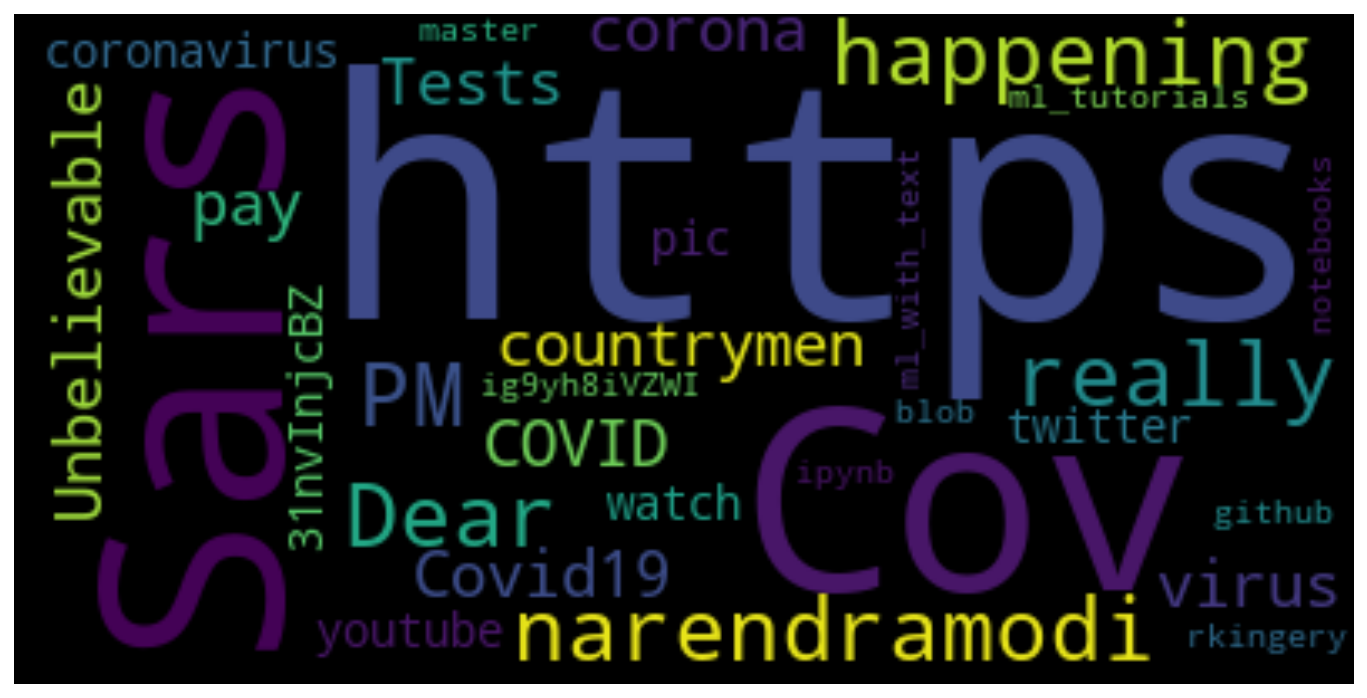

In [41]:
# wordcloud of unclean data
wordcloud = WordCloud().generate(testtweet)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

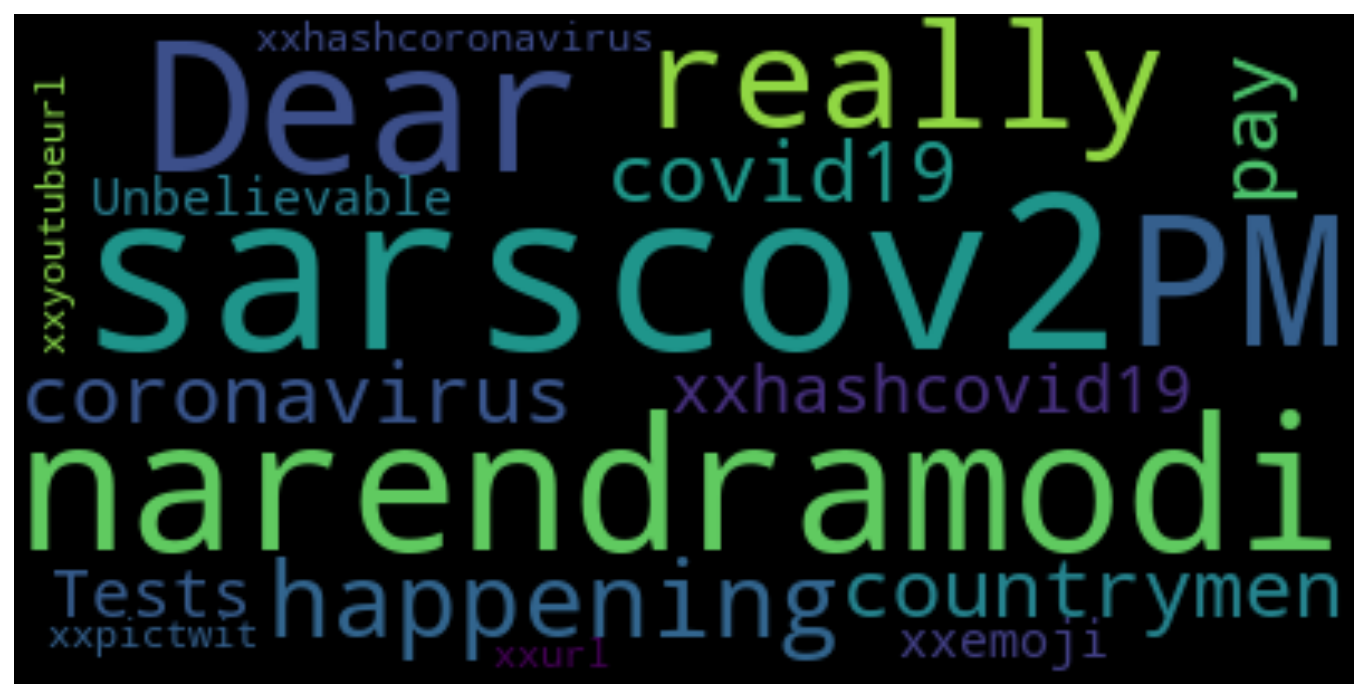

In [42]:
# wordcloud of clean tweet
wordcloud = WordCloud().generate(cleantweet)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

### _WordCloud of Entire Day's Data_

Next we'll take a look at a WordCloud generate with an entire day's worth of Tweets! More specifically, we'll be looking at all the Tweets gathered for **March 24th, 2020**. Next, we'll apply our `clean_wrapper` function to the `tweet` column, and then generate some wordclouds.

The first one we'll create is with all the text and then we'll create one with a set of stop words removed, to eliminate some of the noise (i.e. commonly occurring words). 

In [43]:
# subset of Tweets that fall on 2020-03-24
df_0324 = df['2020-03-24']

# apply clean_wrapper function
processed_tweet = df_0324['tweet'].progress_apply(lambda x: clean_wrapper(x, nltk_tokenize=True))

In [44]:
# create stopword list
stopwords = set(STOPWORDS)
stopwords.update([
    'xxhashcovid19', 'xxemoji', 'xxhashcoronavirus', 'xxurl', 'xxpictwit', 'xxyoutubeurl'
])

In [45]:
# create one long string for wordcloud
text = ' '.join([word for word in processed_tweet])

### _WordCloud of All Text_

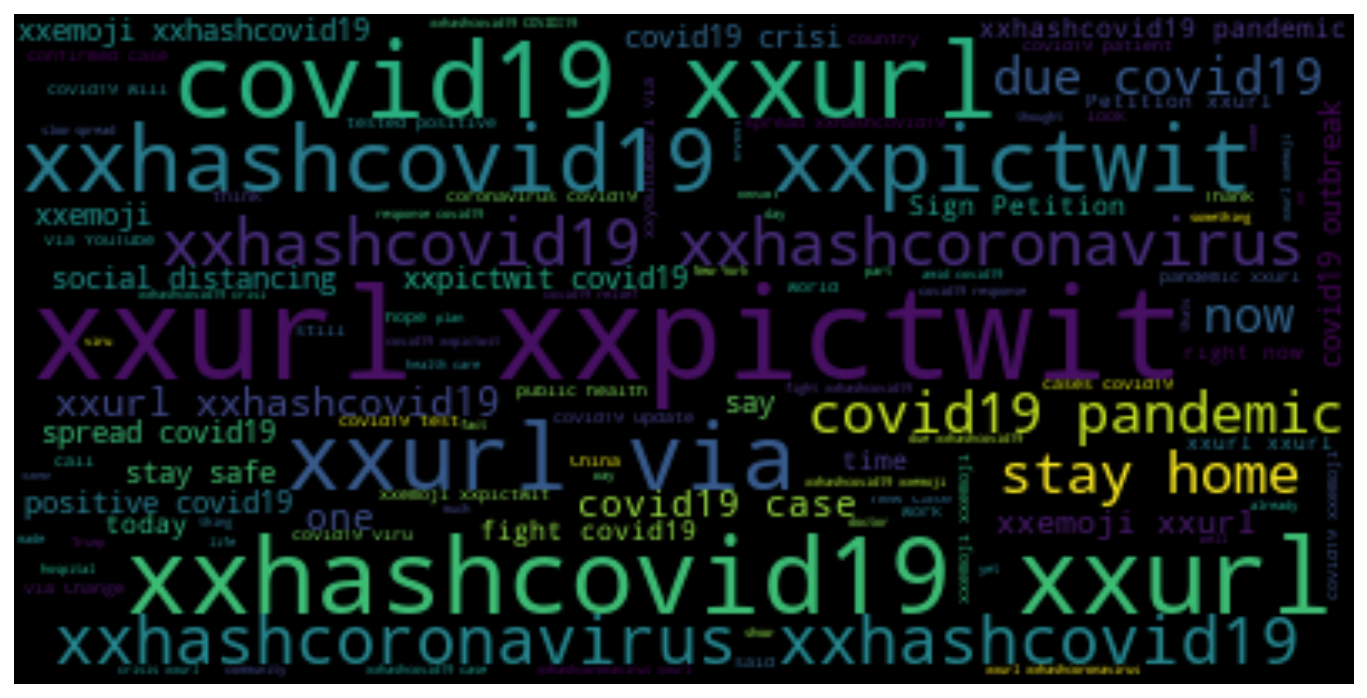

In [46]:
wordcloud_0324 = WordCloud().generate(text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud_0324, interpolation='bilinear')
plt.axis('off');

### _WordCloud of Text Minus Stop Words_

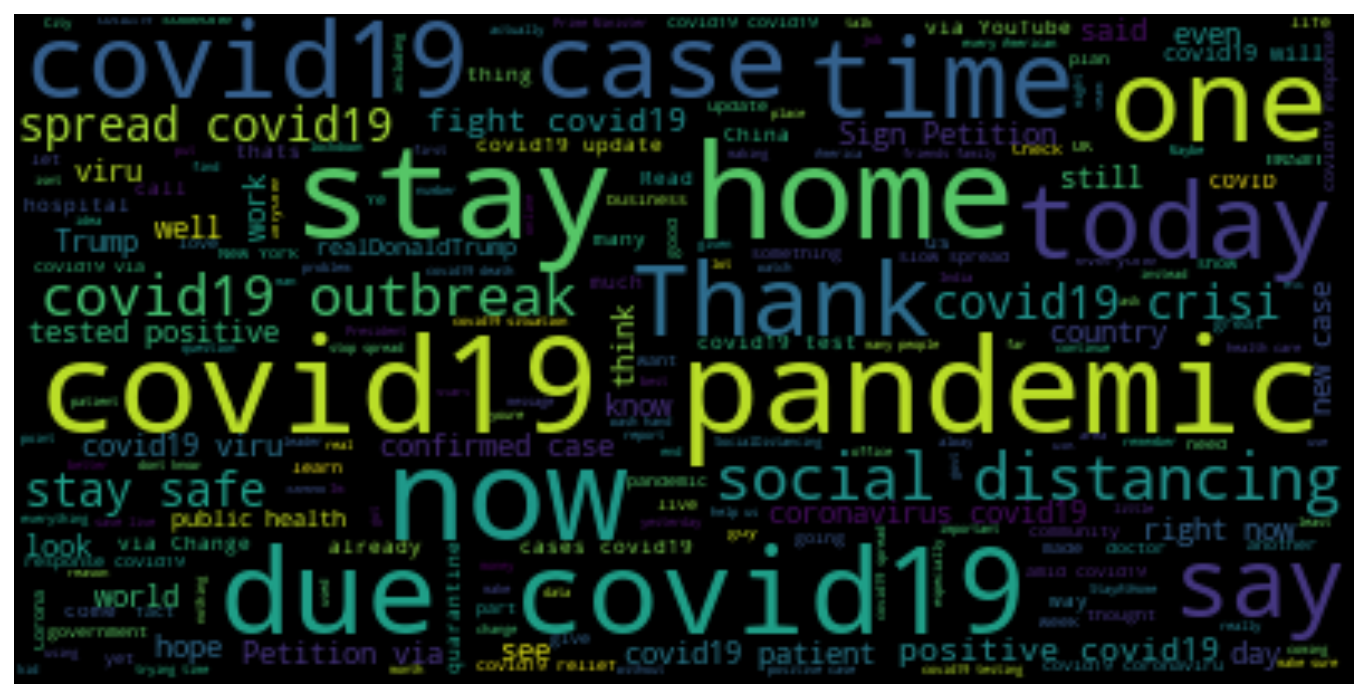

In [47]:
wordcloud_0324_stop = WordCloud(stopwords=stopwords).generate(text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud_0324_stop, interpolation='bilinear')
plt.axis('off');

**To Be Continued...**